In [1]:
%matplotlib inline
import os
os.environ['CUDA_VISIBLE_DEVICES'] = ''

In [2]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import tensorflow as tf
sess = tf.InteractiveSession()

/home/zbc/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
img_list = !ls data/train/
for i in range(len(img_list)):
    img_list[i] = 'data/train/' + img_list[i]

In [5]:
class data_aug():
    def __init__(self, sess, img_list, crops_per_img=10, 
                 aug_types=['flip_left_right', 'flip_up_down']):
        self.session = sess
        self.img_list = img_list
        self.crops_per_img = crops_per_img
        self.aug_types = aug_types
        self.crop_list = []
        
    def open_file_crop(self):
        for idx, img in enumerate(self.img_list):
            raw_img = Image.open(img)
            img_array = np.array(raw_img)
            img_tensor = tf.random_crop(img_array, (128, 128, 3))
            for crop_idx in range(self.crops_per_img):
                crop_img = img_tensor.eval()
                crop_img = Image.fromarray(crop_img)
                save_path = 'aug_data/train/{0}_{1}.png'.format(idx, crop_idx)
                crop_img.save(save_path)
                self.crop_list.append(save_path)
        
    
    def open_file_aug(self):
        # flip left and right and random rotate
        assert len(self.crop_list) > 0
        for idx, crop in enumerate(self.crop_list):
            raw_img = tf.gfile.Open(crop, 'rb').read()
            img_data = tf.image.decode_image(raw_img, channels=3)
            img_data = tf.image.convert_image_dtype(img_data, tf.float32)
            aug_imgs = [img_data.eval()]
            aug_imgs.append(tf.image.flip_left_right(img_data).eval())
            aug_imgs.append(self._random_rotate(aug_imgs[0]))
            aug_imgs.append(self._random_rotate(aug_imgs[0]))
            aug_imgs.append(self._random_rotate(aug_imgs[1]))
            aug_imgs.append(self._random_rotate(aug_imgs[1]))
            for 
    
    def _random_rotate(self, img, low_angle=1, high_angle=8):
        assert type(img) == np.ndarray
        import random
        img_r = Image.fromarray(img).rotate(random.randint(low_angle, high_angle))

In [6]:
(1048 + 585) * 10 * 6 * 0.8

78384.0

In [20]:
raw_img = tf.gfile.Open(img_list[0], 'rb').read()
img_data = tf.image.decode_image(raw_img, channels=3)
img_data = tf.image.convert_image_dtype(img_data, tf.float32)
img_filp_lr = tf.image.random_contrast(img_data, 0., 4.)

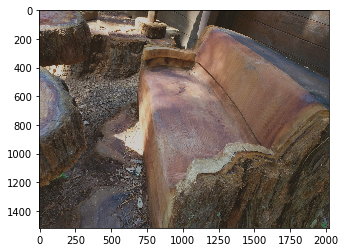

In [21]:
plt.imshow(img_filp_lr.eval())

In [30]:
type(np.array(img_r)) == np.ndarray

True

In [ ]:
img_r.rotate()